Homework 6 <br>
Sam Odle

In [3]:
import torch
from torch.backends import cudnn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from torch import nn, optim
import torch.nn.functional as F
import random
import warnings
import argparse

GPU Implementation

In [4]:
CUDA_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(CUDA_DEVICE)


print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)


cuda
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 2080 Ti
__CUDA Device Total Memory [GB]: 11.810832384


### Download the Fashion MNIST dataset

And convert it into a format (a tensor) that pytorch understands. A tensor can be thought of as matrix (you get to define the dimensions).

Feed the raw images and their labels into a DataLoader that will serve them up in batches to train the model.

In [5]:
# Define a transform for the data
transform = transforms.Compose([transforms.ToTensor()])
#transform.to(device)

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
#trainset.to(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
#trainloader.to(device)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
#testset.to(device)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
#testloader.to(device)


### View a sample image and label
We need to reshape the tensor and feed those pixels into a display library

Label of image tensor(1)
(1, 28, 28)


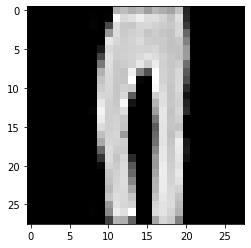

In [6]:
tensor_image, label = next(iter(trainloader)) # returns a batch of images
tensor_image.to(CUDA_DEVICE)
label.to(CUDA_DEVICE)
print("Label of image", label[0])
first_image = numpy.array(tensor_image, dtype='float')[0] # get the first image in the batch
print(first_image.shape)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

### Define your model
We will have three hidden layers, an input later, and then an output layer. All nodes are Linear nodes (using linear activation).

The input layer takes 784 == 28x28 features, corresponding to our greyscale input images.
The three hidden layers have 256, 128, and 64 neurons respectively; each previous layer's neurons all feed into each neuron in the next layer ("fully connected").
The final layer has ten neurons, one representing each of the ten possible classes for this model.

Under the forward method, we define the activation function for each later: we're using ReLu for all the hidden layers. In the last layer, we're switching to softmax so we can get the probabilities for each class.

In [7]:
# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1) # -1 means we'll let the computer figure out how many rows to include
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        
        return x

### Training the model
We choose a learning rate (lr) and some number of epochs, with the goal that the loss is going down each epoch until model convergence on the minimum loss (estimated).

In [11]:
# store train and validation loss in separate arrays, one for each epoch, and graph this!! be careful about eval vs train mode

# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier().to(CUDA_DEVICE)
model.to(CUDA_DEVICE) # GPU IMPLEMENTATION
loss_criterion = nn.CrossEntropyLoss()##.to(CUDA_DEVICE)
##loss_criterion.to(CUDA_DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.3)
#optimizer.to(CUDA_DEVICE)

# Train the network here
epochs = 20

val_losses = []
train_losses = []

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    running_loss_V = 0

    model.train()
    #model.to(device)
    for images, labels in trainloader: # processing one batch at a time
        images = images.to(CUDA_DEVICE)
        labels = labels.to(CUDA_DEVICE)
        predictions = model(images) # predict labels
        loss = loss_criterion(predictions, labels) # calculate the loss

        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
        loss.backward() # compute gradients by using the predictions' grad_fn
                        # that was passed to loss_criterion() above -- this is how it
                        # knows what model parameters need updating eventually
                        # (this is confusing IMO and not obvious to those used to OOP)
        optimizer.step() # using gradients just calculated for model parameters, 
                         # update the weights via the optimizer (which was init with those 
                         # model parameters)

        running_loss += loss.item()

    model.eval()##.to(CUDA_DEVICE)
    for images_V, labels_V in testloader:
        images_V = images_V.to(CUDA_DEVICE)
        labels_V = labels_V.to(CUDA_DEVICE)
        predictions_V = model(images_V) # predict labels
        loss_V = loss_criterion(predictions_V, labels_V) # calculate the loss


        running_loss_V += loss_V.item()

    train_losses.append(running_loss/len(trainloader))
    val_losses.append(running_loss_V/len(testloader))

    print(f"\tTraining loss: {running_loss/len(trainloader)}")
    print(f"\tValidation loss: {running_loss_V/len(testloader)}")

In epoch 0
	Training loss: 1.8692638332655689
	Validation loss: 1.7042128295655463
In epoch 1
	Training loss: 1.684629597770634
	Validation loss: 1.672311230829567
In epoch 2
	Training loss: 1.669388559708463
	Validation loss: 1.6660853973619498
In epoch 3
	Training loss: 1.6610548723735281
	Validation loss: 1.6613141366630604
In epoch 4
	Training loss: 1.657216088476974
	Validation loss: 1.6608641944873106
In epoch 5
	Training loss: 1.6533906703818835
	Validation loss: 1.6711284802977446
In epoch 6
	Training loss: 1.6484404396909131
	Validation loss: 1.6590384093059856
In epoch 7
	Training loss: 1.6445606447486227
	Validation loss: 1.6931577579231019
In epoch 8
	Training loss: 1.6428488124408194
	Validation loss: 1.6724887699078603
In epoch 9
	Training loss: 1.64063304395818
	Validation loss: 1.644675995893539
In epoch 10
	Training loss: 1.6379204823264182
	Validation loss: 1.655404717299589
In epoch 11
	Training loss: 1.6376395280173084
	Validation loss: 1.6994319015247807
In epoch 1

## Graph of Training & Validation Loss

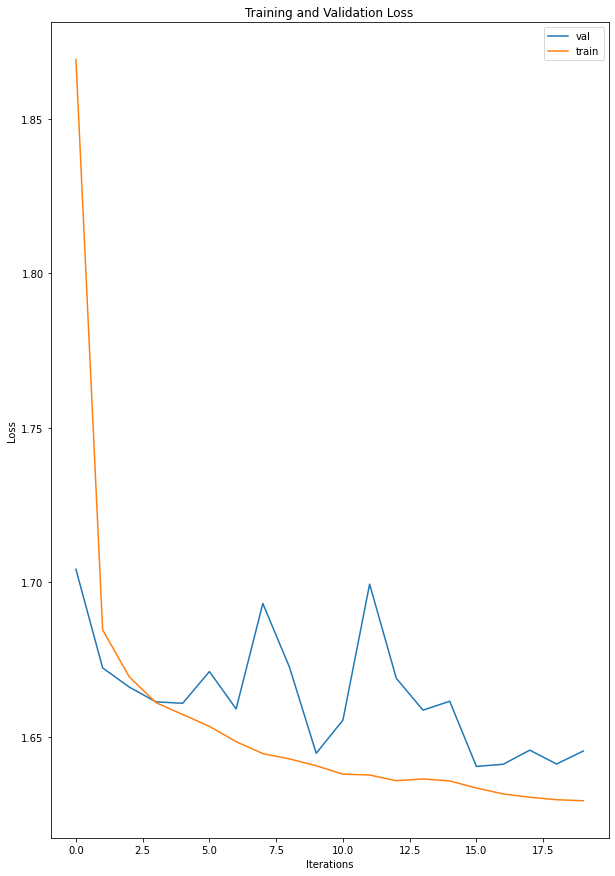

In [12]:
plt.figure(figsize=(10,15))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Training vs Validation Loss Discussion
The validation loss (in blue above) out-performs the training loss (orange) for the first two epochs then is comparable to worse for the remaining epochs.  It is possible, looking at the final four epochs, that the model has started to overfit.  The 4th to last epoch has lower validation loss than the final three epochs. During those same four epochs, the training loss continues to trend downward.   Interestingly the validation loss line only rarely trends in the same direction twice in a row, and never more.  The cause of this may be features or characteristics of images in the validation set that are not in the training set.

<br><br><br>
### Making predictions
Once we've trained the model, we can grab an image and pull out information about its predicted class.

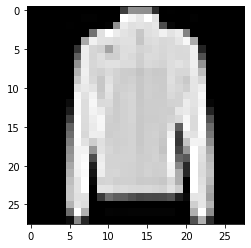

tensor([[3.0806e-23, 1.0171e-17, 1.0058e-04, 2.3033e-15, 9.9990e-01, 9.7217e-15,
         1.9791e-17, 4.0878e-28, 3.0920e-17, 1.2038e-33]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
max_prob 0.9998994
Predicted label:  4
Target label:  4
Successful prediction!


In [17]:
# Test the trained model
tensor_image, label = next(iter(testloader)) # returns a batch of images
tensor_image = tensor_image.to(CUDA_DEVICE)
label = label.to(CUDA_DEVICE)

#print("Target label of image: ", label[0])
first_image = numpy.array(tensor_image.cpu(), dtype='float')[0] # get the first image in the batch

#print(first_image.shape)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

prediction = model(tensor_image[0])
print(prediction)
prediction = prediction.cpu().detach().numpy()
max_prob = max(list(numpy.array(prediction)[0]))
print('max_prob', max_prob)
predicted_label = list(prediction[0]).index(max_prob)
print("Predicted label: ", predicted_label)

tgt_lbl = label[0].item()
print("Target label: ", tgt_lbl)

if tgt_lbl == predicted_label:
    print("Successful prediction!")
else:
    print("Not quite...")

### Accuracy for each batch

In [19]:
# Test the trained model
tensor_image, label = next(iter(testloader)) # returns a batch of images
tensor_image = tensor_image.to(CUDA_DEVICE)
label = label.to(CUDA_DEVICE)

correct = 0
incorrect = 0

for i in range(len(label.tolist())):
    first_image = numpy.array(tensor_image.cpu(), dtype='float')[i] # get the first image in the batch

    prediction = model(tensor_image[i])
    prediction = prediction.cpu().detach().numpy()
    max_prob = max(list(numpy.array(prediction)[0]))
    predicted_label = list(prediction[0]).index(max_prob)

    if label[i].item() == predicted_label:
        correct += 1
        print('+', end = '')
    else:
        incorrect += 1
        print(predicted_label, end = '') #let's take a look at what we're missing

accuracy = round(correct * 100 / (correct + incorrect), 2)
print('')
print(f'Accuracy: {accuracy}% for {correct + incorrect} images.')

++++++++4+++0++7++++++++++30++++++++++++++4++++++++3+0+++++++4++
Accuracy: 85.94% for 64 images.


### Playground

What happens when you: <br>
 <br>**1. Use a much smaller learning rate for the model?** <br>
    Using the initial learning rate of 0.3, the model settles into a loss of ~1.7 after 7/8 epochs. <br>
User larger learning rates (around 0.5), the lost evens out quicker but appears to remain more variable after the mean appears to stabilize.

<br> <br>**2. Feed in the entire test dataset to the model, to make predictions? Could you write code to do this, and measure your model performance?** <br>

In [22]:
# This is not quite right...    Test on ALL the images
correct_net = 0
incorrect_net = 0

for imagesX, labelsX in testloader:
    imagesX = imagesX.to(CUDA_DEVICE)
    labelsX = labelsX.to(CUDA_DEVICE)
    for i in range(len(labelsX.tolist())):
        first_image = numpy.array(imagesX.cpu(), dtype='float')[i] # get the ith image in the batch

        prediction = model(imagesX[i])
        prediction = prediction.cpu().detach().numpy()
        max_prob = max(list(numpy.array(prediction)[0]))
        predicted_label = list(prediction[0]).index(max_prob)

        #print(f' {label[i].item()}/{predicted_label}', end = '')

        if label[i].item() == predicted_label:
            correct_net += 1
            #print('+', end = '')
        else:
            incorrect_net += 1
            #print(predicted_label, end = '') #let's take a look at what we're missing


accuracy_net = round(correct_net * 100 / (correct_net + incorrect_net), 2)
print(f'Accuracy: {accuracy_net}% for {correct_net + incorrect_net} images.')

Accuracy: 10.49% for 10000 images.


  <br> <br>**3. Train the model on only one epoch?** <br>
Training the model on only one epoch results in even higher loss & likely some gross underfitting.